# PART 3: Processes on networks

In [36]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig
import random

## Load 5 networks

In [12]:
# load network 1 (part 1) -  largest component of retweet network
file_path_pkl = '../output/retweet_network_new.pkl'
with open(file_path_pkl, 'rb') as f:
    network_rt_new = pickle.load(f)

In [8]:
type(network_rt_new)

igraph.Graph

In [30]:
# load network 2 (part 2) -  ER model network
file_path_pkl = 'er_network_data.pkl'
with open(file_path_pkl, 'rb') as f:
    er_network = pickle.load(f)
# load network 3 (part 2) -  BA model network
file_path_pkl = 'ba_network_data.pkl'
with open(file_path_pkl, 'rb') as f:
    ba_network = pickle.load(f)
# load network 4 (part 3) -  WS model network
file_path_pkl = 'ws_network_data.pkl'
with open(file_path_pkl, 'rb') as f:
    ws_network = pickle.load(f)
# load network 5 (part 3) -  rewired network 1
file_path_pkl = 'rewired_network_data.pkl'
with open(file_path_pkl, 'rb') as f:
    rewired_network = pickle.load(f)

In [31]:
er_network = ig.Graph.from_networkx(er_network)
ba_network = ig.Graph.from_networkx(ba_network)
ws_network = ig.Graph.from_networkx(ws_network)
rewired_network = ig.Graph.from_networkx(rewired_network)

## Task 3.1 - random walk

*Simulate a process where a token is passed from actor to actor over the network. Every time an actor obtains the token, increase a counter on that actor. Then the actor passes the token to one of its neighbours, picked uniformly at random. This token can be interpreted as someone randomly walking across the graph - that is, this is an implementation of a random walk. The function you should write takes the graph, a starting actor, and the number of iterations as input, and returns the value of the counter for all actors in the network. Do you expect and can you find any relation between the values of the counters and the distance from the input actor, for the five networks? Can you use this function to highlight differences between the different networks (real, synthetic, and rewired)?*

*TIPS:*

*- to write this function you need to extract the neighbors() of some actors, and perform random choices (for example using Python's random module).*

In [38]:
def simulate_random_walk(graph, start_actor, iterations):
    """
    模拟随机游走：token 在网络上传递。
    每次访问一个节点，其计数器加1。
    """
    counters = [0] * graph.vcount()  # 每个节点的访问次数
    current = start_actor
    
    for _ in range(iterations):
        counters[current] += 1
        neighbors = graph.neighbors(current)
        if not neighbors:
            break
        current = random.choice(neighbors)
    
    return counters

In [39]:
counts_rt = simulate_random_walk(network_rt_new, start_actor=0, iterations=10000)
counts_er = simulate_random_walk(er_network, start_actor=0, iterations=10000)
counts_ba = simulate_random_walk(ba_network, start_actor=0, iterations=10000)
counts_ws = simulate_random_walk(ws_network, start_actor=0, iterations=10000)
counts_rw = simulate_random_walk(rewired_network, start_actor=0, iterations=10000)

Real network:
correlation: -0.3535036362118241


C:\Users\Highway\AppData\Local\Temp\ipykernel_464\616734866.py:8: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  distances = network_rt_new.shortest_paths(0)[0]


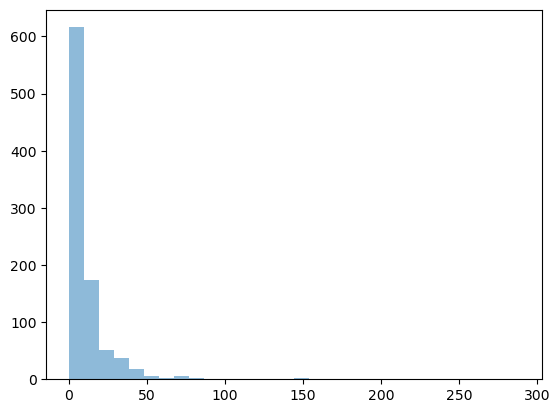

ER network:
correlation: 0.05897513808852131


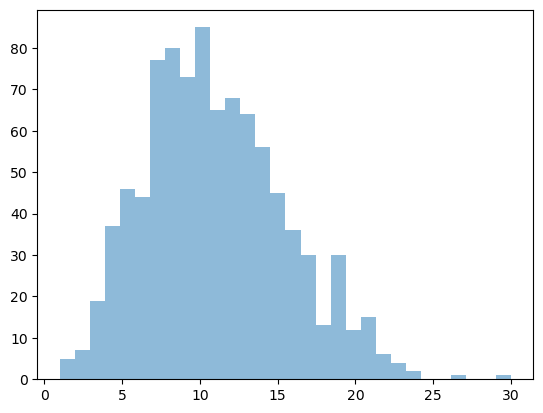

BA network:
correlation: 0.007499364696756387


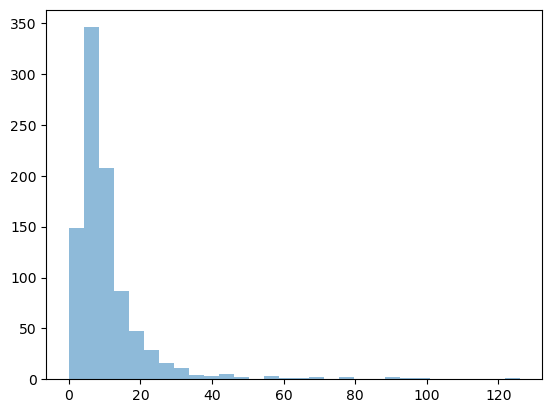

WS network:
correlation: -0.031592770482644174


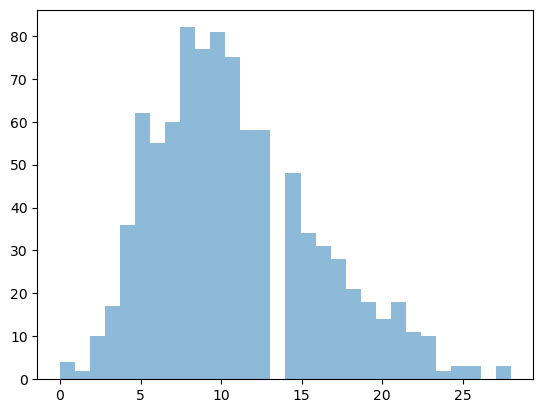

Rewired network:
correlation: -0.3512944120399887


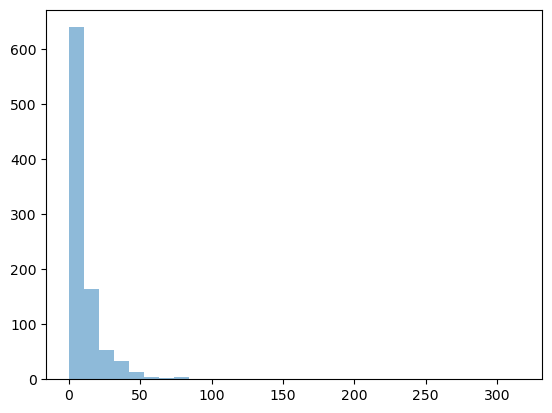

In [92]:
counts = {"Real": counts_rt,
          "ER": counts_er,
          "BA": counts_ba,
          "WS": counts_ws,
          "Rewired": counts_rw}

for name, count in counts.items():
    distances = network_rt_new.shortest_paths(0)[0]
    print(f"{name} network:")
    print(f"correlation: {np.corrcoef(distances, count)[0, 1]}")
    plt.hist(count, bins=30, alpha=0.5, label=name)
    plt.show()


In [75]:
for counts in [counts_rt, counts_er, counts_ba, counts_ws, counts_rw]:
    distances = network_rt_new.shortest_paths(0)[0]
    print(np.corrcoef(distances, counts)[0, 1])

-0.3535036362118241
0.05897513808852131
0.007499364696756387
-0.031592770482644174
-0.3512944120399887


C:\Users\Highway\AppData\Local\Temp\ipykernel_464\966037879.py:2: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  distances = network_rt_new.shortest_paths(0)[0]


**Analysis:**

In the random walk experiment, the correlation between node distance from the starting actor and the number of times the token visited each node was found to be negative for the real and rewired networks, but nearly zero for synthetic ones (ER, BA, WS).
This suggests that in networks with strong community or clustering structures, the token tends to remain within the local neighborhood of the starting node.
In contrast, in more homogeneous or hub-based networks, the walk spreads more uniformly, leading to weak or no correlation with distance.

## Task 3.2 - diffusion process

*Simulate an information diffusion process, where some information is spread over the network. Assume that every actor is in one of two possible states: + (i.e. the actor has already seen the entity that is being spread), or - (i.e. the actor has not yet seen it). The function you should write takes the graph, a starting actor, the number of iterations, and the probability beta of diffusion. At each iteration, all + actors will go through their neighbours one by one and with probability beta will pass the information (that is, set the neighbour's state to +) at the end of this iteration. The function should return the number of actors with state +. Using this function and the five networks, provide evidence regarding the factors increasing or decreasing the speed of diffusion.*

In [76]:
def simulate_information_diffusion(graph, start_actor, iterations, beta):
    """
    模拟信息扩散：+ 表示已获得信息，- 表示未获得。
    """
    states = ['-'] * graph.vcount()
    states[start_actor] = '+'
    
    for _ in range(iterations):
        new_states = states.copy()
        for v in range(graph.vcount()):
            if states[v] == '+':
                for n in graph.neighbors(v):
                    if states[n] == '-' and random.random() < beta:
                        new_states[n] = '+'
        states = new_states
    
    return states.count('+')


### Counts v.s. β

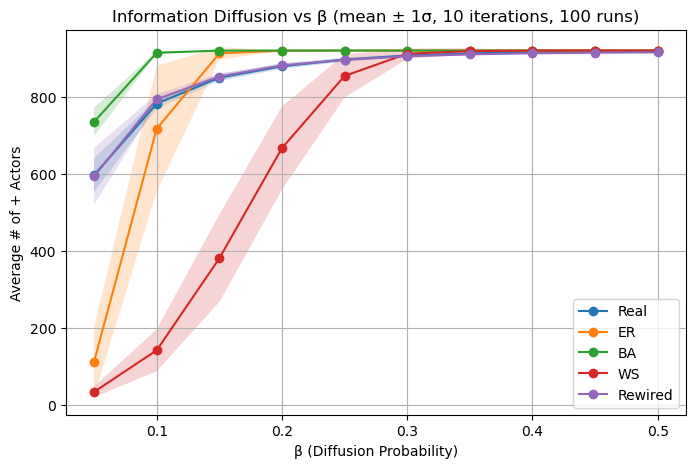

In [91]:
def avg_information_diffusion(graph, start_actor, iterations, betas, runs=10):
    """对不同 β 重复多次实验，返回均值与标准差"""
    means, stds = [], []
    for beta in betas:
        counts = [simulate_information_diffusion(graph, start_actor, iterations, beta) for _ in range(runs)]
        means.append(np.mean(counts))
        stds.append(np.std(counts))
    return np.array(means), np.array(stds)

# 参数设置
betas = np.linspace(0.05, 0.5, 10)
iterations = 10
runs = 100
start_actor = 0

networks = {
    "Real": network_rt_new,
    "ER": er_network,
    "BA": ba_network,
    "WS": ws_network,
    "Rewired": rewired_network
}

plt.figure(figsize=(8,5))
for name, g in networks.items():
    means, stds = avg_information_diffusion(g, start_actor, iterations, betas, runs)
    plt.plot(betas, means, marker='o', label=name)
    plt.fill_between(betas, means - stds, means + stds, alpha=0.2)

plt.xlabel("β (Diffusion Probability)")
plt.ylabel("Average # of + Actors")
plt.title(f"Information Diffusion vs β (mean ± 1σ, {iterations} iterations, {runs} runs)")
plt.legend()
plt.grid(True)
plt.show()

This figure shows how the average number of infected (or activated) nodes changes with the diffusion probability β across different network models.

We can see that:

- **Real** and **BA** networks reach saturation (around 900+ nodes) very quickly, even when β is as low as 0.1.

- **ER** and **Rewired** networks show a similar but slightly delayed trend.

- **WS** (Watts–Strogatz small-world) network has a much slower diffusion, requiring a much higher β to reach a comparable level.

The shaded areas (±1σ) indicate variability due to random seeding or randomness in diffusion. WS and ER networks show larger variance at intermediate β values, suggesting more uncertainty in their diffusion paths.

Overall, networks with heterogeneous degree distributions (like BA and Real) facilitate diffusion more efficiently, because high-degree hubs accelerate information spread.

### Counts v.s. Interations

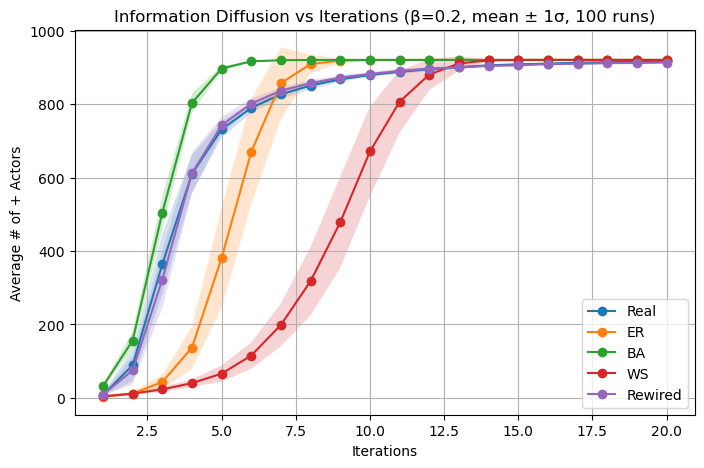

In [90]:
def avg_information_vs_iterations(graph, start_actor, iterations_list, beta, runs=10):
    """不同迭代次数下的平均结果（±1σ）"""
    means, stds = [], []
    for it in iterations_list:
        counts = [simulate_information_diffusion(graph, start_actor, it, beta) for _ in range(runs)]
        means.append(np.mean(counts))
        stds.append(np.std(counts))
    return np.array(means), np.array(stds)

# 参数
iterations_list = range(1, 21)   # 1~20次迭代
beta = 0.2
runs = 100
start_actor = 0

plt.figure(figsize=(8,5))
for name, g in networks.items():
    means, stds = avg_information_vs_iterations(g, start_actor, iterations_list, beta, runs)
    plt.plot(iterations_list, means, marker='o', label=name)
    plt.fill_between(iterations_list, means - stds, means + stds, alpha=0.2)

plt.xlabel("Iterations")
plt.ylabel("Average # of + Actors")
plt.title(f"Information Diffusion vs Iterations (β={beta}, mean ± 1σ, {runs} runs)")
plt.legend()
plt.grid(True)
plt.show()


This figure tracks the temporal dynamics of diffusion (number of infected nodes vs iteration step) under β=0.2.

- The patterns are consistent with the previous plot:

- **BA** and **Real** networks show the fastest diffusion — they reach almost full activation within 6–8 iterations.

- **ER** and **Rewired** networks follow slightly behind.

- **WS** network again shows the slowest growth, only catching up after ~12 iterations.

The smaller shaded regions for Real and BA networks indicate more stable diffusion behaviors, while WS and ER networks exhibit greater variability due to randomness and structural regularity.

**Overall**, the experiments suggest that diffusion efficiency is strongly influenced by the network topology.
Real and BA networks (with scale-free properties and hub nodes) promote faster and more consistent information spread, while WS and ER networks require higher β or longer iterations to achieve the same level of diffusion.

## Task 3.3 - diffusion process

*Simulate an opinion diffusion process. As in Task 2, actors have two possible states + and -, representing opinions. At the beginning, all actors have opinion -. The function you should write takes the graph, the number of actors whose opinion should be set to +, the number of iterations, and the opinion change threshold th. At each iteration, all actors with state + will count the number of their neighbours with opinion + and -, and if the proportion of - is higher than or equal to the threshold th, the actor will change its opinion to - at the end of this iteration. The function should return the number of actors with state +. Using this function and the five networks, provide evidence regarding the factors increasing or decreasing the speed of adoption of a new opinion.*

In [72]:
def simulate_opinion_diffusion(graph, num_initial_plus, iterations, threshold):
    """
    模拟观点传播与逆转。
    """
    states = ['-'] * graph.vcount()
    initial_plus = random.sample(range(graph.vcount()), num_initial_plus)
    for i in initial_plus:
        states[i] = '+'
    
    for _ in range(iterations):
        new_states = states.copy()
        for v in range(graph.vcount()):
            if states[v] == '+':
                neighbors = graph.neighbors(v)
                if not neighbors:
                    continue
                n_minus = sum(states[n] == '-' for n in neighbors)
                proportion_minus = n_minus / len(neighbors)
                if proportion_minus >= threshold:
                    new_states[v] = '-'
        states = new_states
    
    return states.count('+')


### Count v.s. #instial seeds

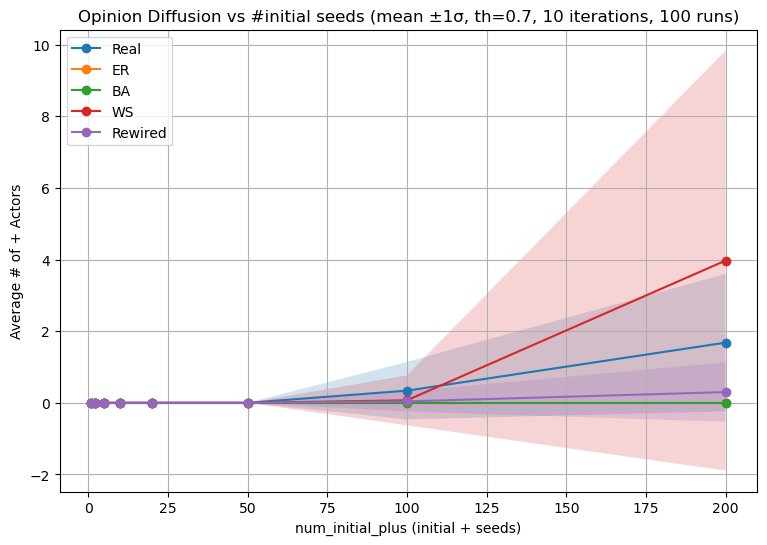

In [101]:
def avg_opinion_vs_seed_count(graph, num_initial_list, iterations, threshold, runs=50):
    """
    对给定图，针对 num_initial_list 中的每个值做 runs 次实验，
    返回 means (len=num_initial_list) 和 stds。
    """
    means, stds = [], []
    for num_init in num_initial_list:
        results = [simulate_opinion_diffusion(graph, num_init, iterations, threshold) for _ in range(runs)]
        means.append(np.mean(results))
        stds.append(np.std(results))
    return np.array(means), np.array(stds)

# 参数设置
num_initial_list = [1, 2, 5, 10, 20, 50, 100, 200]  
iterations = 10
threshold = 0.7
runs = 100

plt.figure(figsize=(9,6))
for name, g in networks.items():
    means, stds = avg_opinion_vs_seed_count(g, num_initial_list, iterations, threshold, runs=runs)
    x = np.array(num_initial_list)
    plt.plot(x, means, marker='o', label=name)
    plt.fill_between(x, means - stds, means + stds, alpha=0.2)

plt.xlabel("num_initial_plus (initial + seeds)")
plt.ylabel("Average # of + Actors")
plt.title(f"Opinion Diffusion vs #initial seeds (mean ±1σ, th={threshold}, {iterations} iterations, {runs} runs)")
plt.legend()
plt.grid(True)
plt.show()

### Counts v.s. Threshold

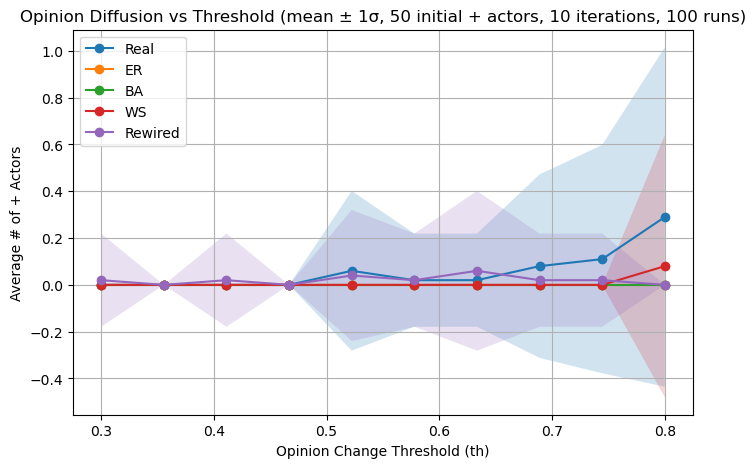

In [96]:
def avg_opinion_diffusion(graph, num_initial_plus, iterations, thresholds, runs=10):
    """对不同 threshold 多次实验，返回均值与标准差"""
    means, stds = [], []
    for th in thresholds:
        counts = [simulate_opinion_diffusion(graph, num_initial_plus, iterations, th) for _ in range(runs)]
        means.append(np.mean(counts))
        stds.append(np.std(counts))
    return np.array(means), np.array(stds)

# 参数设置
thresholds = np.linspace(0.3, 0.8, 10)
iterations = 10
runs = 100
num_initial_plus = 50

plt.figure(figsize=(8,5))
for name, g in networks.items():
    means, stds = avg_opinion_diffusion(g, num_initial_plus, iterations, thresholds, runs)
    plt.plot(thresholds, means, marker='o', label=name)
    plt.fill_between(thresholds, means - stds, means + stds, alpha=0.2)

plt.xlabel("Opinion Change Threshold (th)")
plt.ylabel("Average # of + Actors")
plt.title(f"Opinion Diffusion vs Threshold (mean ± 1σ, {num_initial_plus} initial + actors, {iterations} iterations, {runs} runs)")
plt.legend()
plt.grid(True)
plt.show()

### Counts v.s. Interations

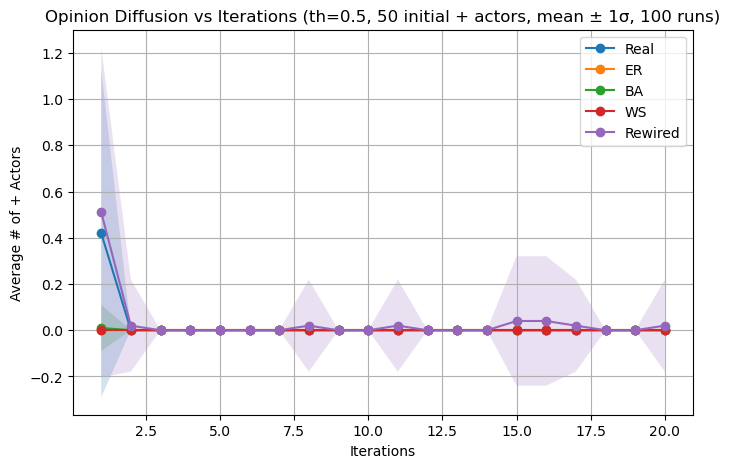

In [95]:
def avg_opinion_vs_iterations(graph, num_initial_plus, iterations_list, threshold, runs=10):
    """不同迭代次数下的平均结果（±1σ）"""
    means, stds = [], []
    for it in iterations_list:
        counts = [simulate_opinion_diffusion(graph, num_initial_plus, it, threshold) for _ in range(runs)]
        means.append(np.mean(counts))
        stds.append(np.std(counts))
    return np.array(means), np.array(stds)

# 参数
iterations_list = range(1, 21)
threshold = 0.5
runs = 100
num_initial_plus = 50

plt.figure(figsize=(8,5))
for name, g in networks.items():
    means, stds = avg_opinion_vs_iterations(g, num_initial_plus, iterations_list, threshold, runs)
    plt.plot(iterations_list, means, marker='o', label=name)
    plt.fill_between(iterations_list, means - stds, means + stds, alpha=0.2)

plt.xlabel("Iterations")
plt.ylabel("Average # of + Actors")
plt.title(f"Opinion Diffusion vs Iterations (th={threshold}, {num_initial_plus} initial + actors, mean ± 1σ, {runs} runs)")
plt.legend()
plt.grid(True)
plt.show()


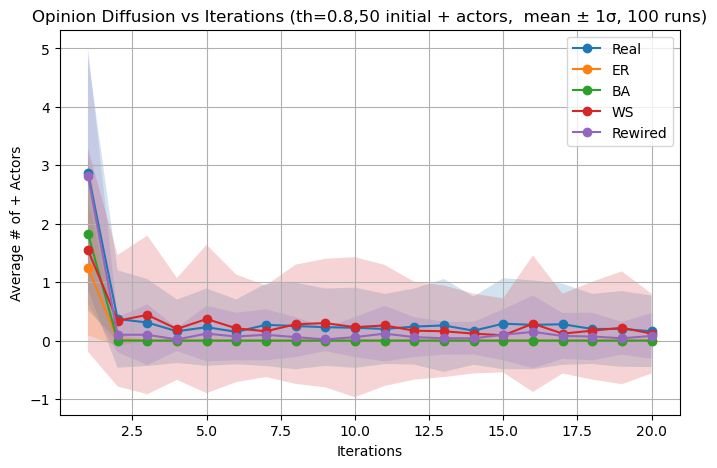

In [94]:
# 参数
iterations_list = range(1, 21)
threshold = 0.8
runs = 100
num_initial_plus = 50

plt.figure(figsize=(8,5))
for name, g in networks.items():
    means, stds = avg_opinion_vs_iterations(g, num_initial_plus, iterations_list, threshold, runs)
    plt.plot(iterations_list, means, marker='o', label=name)
    plt.fill_between(iterations_list, means - stds, means + stds, alpha=0.2)

plt.xlabel("Iterations")
plt.ylabel("Average # of + Actors")
plt.title(f"Opinion Diffusion vs Iterations (th={threshold},{num_initial_plus} initial + actors,  mean ± 1σ, {runs} runs)")
plt.legend()
plt.grid(True)
plt.show()

- The more initial seeds and a higher threshold can both increase the speed of adoption of a new opinion.

- Clustering is the Key - This opinion model is a direct test of network clustering. High-cluster networks (Real, WS) can sustain opinions. Low-cluster networks (ER, BA) cannot.

- Rewired Model is the "Control". It has the same degree distribution as the Real network, but its clustering is destroyed.

- The Big Takeaway: Because the Rewired network fails as badly as the ER and BA networks, this proves that degree distribution (having hubs) is irrelevant for this process. It is only the community structure (clustering) that allows an opinion to persist.